In [18]:
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
import os
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Define the folder path containing the CSV files
folder_path = '/Users/marclambertes/Python/Matches/Men/2024-2025/Eredivisie 2024-2025'

# Initialize an empty list to store DataFrames
dataframes = []

# Loop through all files in the folder
for file_name in os.listdir(folder_path):
    # Check if the file is a CSV
    if file_name.endswith('.csv'):
        # Construct the full file path
        file_path = os.path.join(folder_path, file_name)
        # Read the CSV file into a DataFrame
        df = pd.read_csv(file_path)
        # Append the DataFrame to the list
        dataframes.append(df)

# Combine all DataFrames into a single DataFrame
df = pd.concat(dataframes, ignore_index=True)

# Extract qualifier columns
type_cols = [col for col in df.columns if '/qualifierId' in col]

# Initialize endX and endY columns
df['endX'] = 0.0
df['endY'] = 0.0

# Populate endX and endY based on qualifiers
for i in range(len(df)):
    df1 = df.iloc[i:i+1, :]
    for j in range(len(type_cols)):
        col = df1[type_cols[j]].values[0]
        if col == 140:  # Qualifier for endX
            endx = df1.loc[:, 'qualifier/%i/value' % j].values[0]
            df.at[i, 'endX'] = endx
        elif col == 141:  # Qualifier for endY
            endy = df1.loc[:, 'qualifier/%i/value' % j].values[0]
            df.at[i, 'endY'] = endy

# Initialize ThrowIn column
df['ThrowIn'] = 0

# Populate ThrowIn based on qualifiers
for i in range(len(df)):
    df1 = df.iloc[i:i+1, :]
    for j in range(len(type_cols)):
        col = df1[type_cols[j]].values[0]
        if col == 107:  # Qualifier for ThrowIn
            df.at[i, 'ThrowIn'] = 1

# Initialize pass_angle and pass_length columns
df['pass_angle'] = 0.0
df['pass_length'] = 0.0

# Populate pass_angle and pass_length based on qualifiers
for i in range(len(df)):
    df1 = df.iloc[i:i+1, :]
    for j in range(len(type_cols)):
        col = df1[type_cols[j]].values[0]
        if col == 213:  # Qualifier for pass_angle
            angle = df1.loc[:, 'qualifier/%i/value' % j].values[0]
            df.at[i, 'pass_angle'] = angle
        elif col == 212:  # Qualifier for pass_length
            length = df1.loc[:, 'qualifier/%i/value' % j].values[0]
            df.at[i, 'pass_length'] = length

# Ensure all required columns are numeric
df['pass_length'] = pd.to_numeric(df['pass_length'], errors='coerce')
df['pass_angle'] = pd.to_numeric(df['pass_angle'], errors='coerce')
df['x'] = pd.to_numeric(df['x'], errors='coerce')
df['y'] = pd.to_numeric(df['y'], errors='coerce')
df['endX'] = pd.to_numeric(df['endX'], errors='coerce')
df['endY'] = pd.to_numeric(df['endY'], errors='coerce')

# Drop rows with missing values in the features
df = df.dropna(subset=['pass_length', 'pass_angle', 'x', 'y', 'endX', 'endY'])

# Define features (X) and target (y)
# Features: pass_length, pass_angle, start location (x, y), end location (endX, endY)
X = df[['pass_length', 'pass_angle', 'x', 'y', 'endX', 'endY']]

# Target: Assume 'success' column indicates whether the pass was completed (1 = success, 0 = failure)
# If you don't have a 'success' column, you'll need to create one based on your data
# For example, if 'outcome' column exists, you can map it to 1 (success) or 0 (failure)
if 'outcome' in df.columns:
    df['success'] = df['outcome'].apply(lambda x: 1 if x == 'success' else 0)
else:
    # If no outcome column exists, assume all passes are successful (for demonstration purposes)
    df['success'] = 1  # Replace this with actual logic based on your data

# Check the target variable
print(df['success'].value_counts())

# If the target variable contains only one class, adjust it
if df['success'].nunique() == 1:
    print("Warning: The target variable contains only one class. Adjusting the dataset...")
    
    # Example: Randomly assign some passes as failures (for demonstration purposes)
    np.random.seed(42)  # For reproducibility
    df['success'] = np.random.choice([0, 1], size=len(df), p=[0.2, 0.8])  # 20% failures, 80% successes

# Check the target variable again
print(df['success'].value_counts())

# Define features (X) and target (y)
X = df[['pass_length', 'pass_angle', 'x', 'y', 'endX', 'endY']]
y = df['success']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a logistic regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Predict pass completion probability (xPass)
df['xPass'] = model.predict_proba(X)[:, 1]  # Probability of class 1 (success)

# Evaluate model accuracy (optional)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.2f}")

# Import xT Grid, turn it into an array, and then get how many rows and columns it has
xT = pd.read_csv("xT_grid.csv", header=None)
xT = np.array(xT)
xT_rows, xT_cols = xT.shape
print(xT_rows, xT_cols)

# Bin the 'x', 'y', 'endX', and 'endY' columns
df['x1_bin'] = pd.cut(df['x'], bins=xT_cols, labels=False)
df['y1_bin'] = pd.cut(df['y'], bins=xT_rows, labels=False)
df['x2_bin'] = pd.cut(df['endX'], bins=xT_cols, labels=False)
df['y2_bin'] = pd.cut(df['endY'], bins=xT_rows, labels=False)

# Calculate 'start_zone_value' and 'end_zone_value'
df['start_zone_value'] = df[['x1_bin', 'y1_bin']].apply(lambda x: xT[x[1]][x[0]], axis=1)
df['end_zone_value'] = df[['x2_bin', 'y2_bin']].apply(lambda x: xT[x[1]][x[0]], axis=1)

# Calculate 'xT'
df['xT'] = df['end_zone_value'] - df['start_zone_value']

# Import EPV grid
epv = pd.read_csv("epv_grid.csv", header=None)  # Assuming epv_grid.csv was saved earlier
epv = np.array(epv)  # Convert to numpy array
epv_rows, epv_cols = epv.shape  # Get rows and columns
print(epv_rows, epv_cols)

# Ensure coordinate columns are numeric
df['x'] = pd.to_numeric(df['x'], errors='coerce')
df['y'] = pd.to_numeric(df['y'], errors='coerce')
df['endX'] = pd.to_numeric(df['endX'], errors='coerce')
df['endY'] = pd.to_numeric(df['endY'], errors='coerce')

# Check for missing or invalid values in the coordinates
if df[['x', 'y', 'endX', 'endY']].isnull().any().any():
    print("Warning: There are missing or invalid values in the coordinates. Check your data.")

# Map start and end coordinates to EPV zones
df['x1_bin'] = pd.cut(df['x'], bins=epv_cols, labels=False).astype('Int64')
df['y1_bin'] = pd.cut(df['y'], bins=epv_rows, labels=False).astype('Int64')
df['x2_bin'] = pd.cut(df['endX'], bins=epv_cols, labels=False).astype('Int64')
df['y2_bin'] = pd.cut(df['endY'], bins=epv_rows, labels=False).astype('Int64')

# Calculate start and end zone EPV values, ensuring numeric conversion
def get_epv_value(bin_indices, epv_grid):
    if pd.notnull(bin_indices[0]) and pd.notnull(bin_indices[1]):
        return epv_grid[int(bin_indices[1])][int(bin_indices[0])]
    return np.nan  # Return NaN if indices are invalid

df['start_zone_value'] = df[['x1_bin', 'y1_bin']].apply(lambda x: get_epv_value(x, epv), axis=1)
df['end_zone_value'] = df[['x2_bin', 'y2_bin']].apply(lambda x: get_epv_value(x, epv), axis=1)

# Ensure the EPV values are numeric
df['start_zone_value'] = pd.to_numeric(df['start_zone_value'], errors='coerce')
df['end_zone_value'] = pd.to_numeric(df['end_zone_value'], errors='coerce')

# Compute EPV for the action
df['epv'] = df['end_zone_value'] - df['start_zone_value']

# Save the results to an Excel file
df.to_excel("epv_with_xPass.xlsx", index=False)

# Filter the DataFrame based on the conditions
df = df[(df['typeId'] == 1) & (df['ThrowIn'] == 1) & (df['pass_length'] >= 20)]

# Save the filtered DataFrame to an Excel file
df.to_excel('/Users/marclambertes/Python/filtered_throws_with_xPass.xlsx', index=False)

# Display the DataFrame with xPass
print(df[['x', 'y', 'endX', 'endY', 'xPass']].head())

0    371271
Name: success, dtype: int64
1    297219
0     74052
Name: success, dtype: int64
Model Accuracy: 0.80
8 12
82 3
        x      y  endX  endY     xPass
133  64.1  100.0  42.6  63.0  0.798343
499  88.2    0.0  61.3   7.4  0.798643
691  61.8    0.0  63.3  46.1  0.798298
820  77.2    0.0  94.1  20.6  0.800980
889  67.3    0.0  47.0  22.2  0.798510


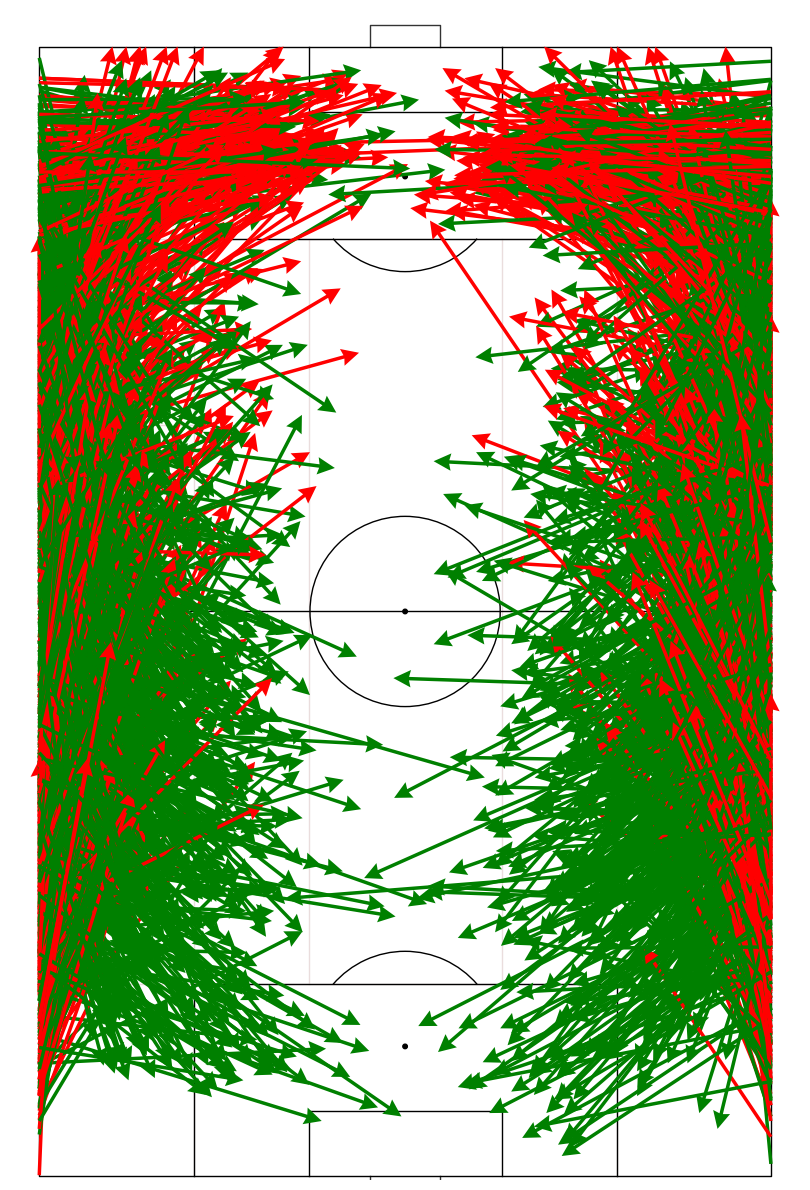

In [19]:
from mplsoccer.pitch import VerticalPitch

# Set up pitch
pitch = VerticalPitch(positional=True, pitch_type='opta', pad_bottom=0.5, pad_top=5, 
                      pitch_color='white', line_color='black', linewidth=1, half=False, 
                      goal_type='box', goal_alpha=0.8)

fig, ax = pitch.draw(figsize=(18, 12))

# Plot crosses (successful in green, unsuccessful in red)
for i, row in df.iterrows():
    color = 'green' if 'outcome' in df.columns and row['outcome'] == 1 else 'red'
    pitch.arrows(row['x'], row['y'], row['endX'], row['endY'], 
                 width=2.5, zorder=2, headwidth=5, headlength=5, color=color, ax=ax)


In [23]:
import pandas as pd

# Load the Excel file
df = pd.read_excel('/Users/marclambertes/Python/filtered_throws_with_xPass.xlsx')

# Debugging: Check the range of x and y
print("x range:", df['x'].min(), df['x'].max())
print("y range:", df['y'].min(), df['y'].max())

# Define the thirds
def categorize_thirds(row):
    x = row['x']
    
    # Defensive third
    if x < 33.33:
        return 'Defensive'
    
    # Middle third
    elif 33.33 <= x < 66.66:
        return 'Middle'
    
    # Attacking third
    else:
        return 'Attacking'

# Define the zones
def categorize_zones(row):
    x, y = row['x'], row['y']
    
    # Zone 14
    if 50 <= x < 75 and 35 <= y < 65:
        return 'Zone 14'
    
    # Right Half-Space
    elif 50 <= x < 100 and 65 <= y < 85:
        return 'Right Half-Space'
    
    # Left Half-Space
    elif 50 <= x < 100 and 15 <= y < 35:
        return 'Left Half-Space'
    
    # Right Wide Area
    elif 50 <= x < 100 and 85 <= y <= 100:
        return 'Right Wide Area'
    
    # Left Wide Area
    elif 50 <= x < 100 and 0 <= y < 15:
        return 'Left Wide Area'
    
    # If none of the above, categorize as 'Other'
    else:
        return 'Other'

# Apply the categorization for thirds
df['third'] = df.apply(categorize_thirds, axis=1)

# Apply the categorization for zones
df['zone'] = df.apply(categorize_zones, axis=1)

# Count the number of throw-ins in each third
third_counts = df['third'].value_counts()

# Count the number of throw-ins in each zone
zone_counts = df['zone'].value_counts()

# Print the results
print("Number of throw-ins in each third:")
print(third_counts)
print("\nNumber of throw-ins in each zone:")
print(zone_counts)

# Optional: Save the categorized data to a new Excel file
df.to_excel('/Users/marclambertes/Python/categorized_throw_ins.xlsx', index=False)

x range: 0.1 99.0
y range: 0 100
Number of throw-ins in each third:
Middle       1510
Attacking    1057
Defensive     692
Name: third, dtype: int64

Number of throw-ins in each zone:
Other              1392
Right Wide Area     942
Left Wide Area      925
Name: zone, dtype: int64


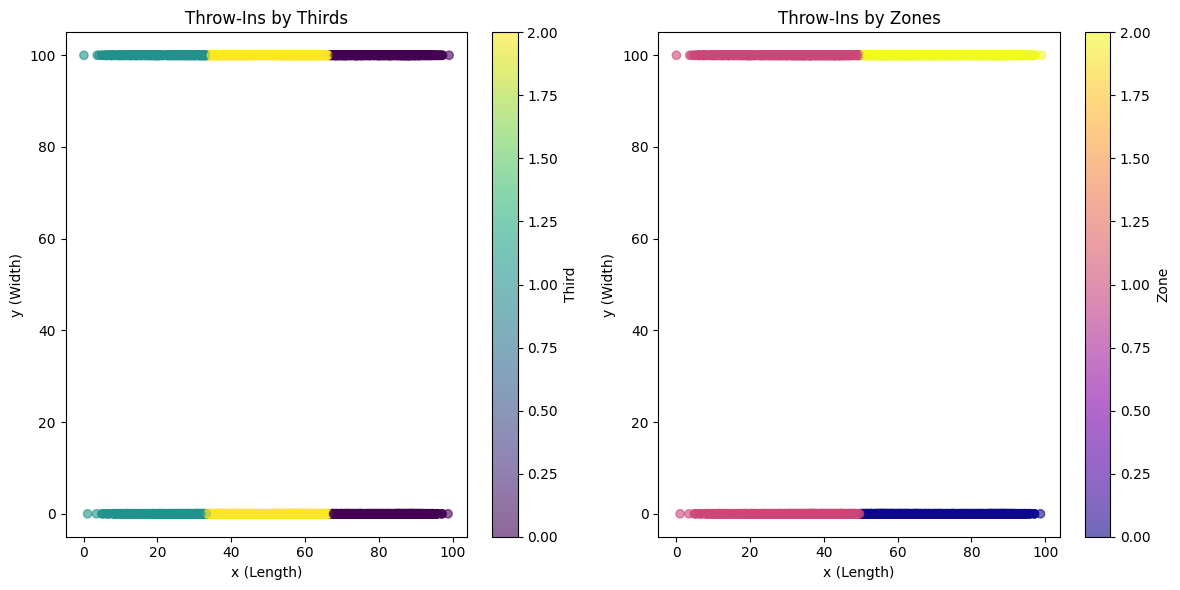

In [24]:
import matplotlib.pyplot as plt

# Plot the throw-ins with thirds and zones
plt.figure(figsize=(12, 6))

# Plot thirds
plt.subplot(1, 2, 1)
plt.scatter(df['x'], df['y'], c=df['third'].astype('category').cat.codes, cmap='viridis', alpha=0.6)
plt.colorbar(label='Third')
plt.xlabel('x (Length)')
plt.ylabel('y (Width)')
plt.title('Throw-Ins by Thirds')

# Plot zones
plt.subplot(1, 2, 2)
plt.scatter(df['x'], df['y'], c=df['zone'].astype('category').cat.codes, cmap='plasma', alpha=0.6)
plt.colorbar(label='Zone')
plt.xlabel('x (Length)')
plt.ylabel('y (Width)')
plt.title('Throw-Ins by Zones')

plt.tight_layout()
plt.show()